# How to train and deploy Learning To Rank

TODO: udpate the link to elastic/elasticsearch-labs instead of my fork before merging.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/afoucret/elasticsearch-labs/blob/ltr-notebook/notebooks/learning-to-rank/01-learning-to-rank.ipynb)

In this notebook we will see example on how to train a Learning To Rank model using [XGBoost](https://xgboost.ai/) and how to deploy it to be used as a rescorer in Elasticsearch.

## Install required packages

First we will be installing packages required for our example.

In [4]:
# TODO: when eland 8.12.1 is released, we can avoid installing from github main:
!pip install git+https://github.com/elastic/eland@main
!pip install elasticsearch "eland[scikit-learn]" xgboost tqdm

from tqdm import tqdm
# Setup the progress bar so we can use progress_apply in the notebook.
tqdm.pandas()

  Cloning https://github.com/elastic/eland (to revision main) to /private/var/folders/g_/zb4vtmp57f1f1bjvhrg0v3qc0000gn/T/pip-req-build-yf32qvq8
  Running command git clone -q https://github.com/elastic/eland /private/var/folders/g_/zb4vtmp57f1f1bjvhrg0v3qc0000gn/T/pip-req-build-yf32qvq8
  Resolved https://github.com/elastic/eland to commit 2a6a4b1f06b39e79a3c67a450193992bf6c0ac0a
You should consider upgrading via the '/Users/afoucret/git/elasticsearch-labs/.venv/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/afoucret/git/elasticsearch-labs/.venv/bin/python3 -m pip install --upgrade pip' command.


## Configure your Elasticsearch deployment

For this example, we will be using an [Elastic Cloud](https://www.elastic.co/guide/en/cloud/current/ec-getting-started.html) deployment (available with a [free trial](https://cloud.elastic.co/registration?utm_source=github&utm_content=elasticsearch-labs-notebook)).

In [5]:
import getpass
from elasticsearch import Elasticsearch

# Found in the "Manage Deployment" page
try: CLOUD_ID
except NameError: CLOUD_ID = getpass.getpass("Enter Elastic Cloud ID: ")

# Password for the "elastic" user generated by Elasticsearch
try: ELASTIC_PASSWORD
except NameError:
    ELASTIC_PASSWORD = getpass.getpass("Enter Elastic password: ")

# Create the client instance
es_client = Elasticsearch(
    cloud_id=CLOUD_ID,
    basic_auth=("elastic", ELASTIC_PASSWORD)
)

client_info = es_client.info()

f"Successfully connected to cluster {client_info['cluster_name']} (version {client_info['version']['number']})"

'Successfully connected to cluster runTask (version 8.13.0-SNAPSHOT)'

## Configuring the dataset

In this example notebook we will use a dataset derived from [MSRD](https://github.com/metarank/msrd/tree/master) (Movie Search Ranking Dataset).

The dataset is available [here](https://github.com/elastic/elasticsearch-labs/tree/main//ltr-notebook/notebooks/learning-to-rank/sample_data/) and contains the following files:

- **movies_corpus.jsonl.gz**
- **movies_judgements.csv.gz**:
- **movies_index_settings.json**

In [6]:
from urllib.parse import urljoin

# TODO: use elastic/elasticsearch-labs instead of afoucret/elasticsearch-labs before merging the PR.

DATASET_BASE_URL = "https://raw.githubusercontent.com/afoucret/elasticsearch-labs/ltr-notebook/notebooks/learning-to-rank/sample_data/"

CORPUS_URL = urljoin(DATASET_BASE_URL, "movies_corpus.jsonl.gz")
JUDGEMENTS_FILE_URL = urljoin(DATASET_BASE_URL,"movies_judgments.csv.gz")
INDEX_SETTINGS_URL = urljoin(DATASET_BASE_URL,"movies_index_settings.json")


 ## Importing the document corpus

This step will import the documents of the corpus into the `movies` index .

Documments contains the following fields:

| Field name   | Description                                 |
|--------------|---------------------------------------------|
| `id`         | Id of the document                          |
| `title`      | Movie title                                 |
| `overview`   | A short description of the movie            |
| `actors`     | List of actors in the movies                |
| `director`   | Director of the movie                       |
| `characters` | List of characters that appear in the movie |
| `genres`     | Genres of the movie                         |
| `year`       | Year the movie was released                 |
| `budget`     | Budget of the movies in USD                 |
| `votes`      | Number of votes received by the movie       |
| `rating`     | Average rating of the movie                 |
| `popularity` | Number use to measure the movie popularity  |
| `tags`       | A list of tags for the movies               |



In [7]:
import json
import elasticsearch.helpers as es_helpers
import pandas as pd
from urllib.request import urlopen

MOVIE_INDEX = "movies"

# Delete index
print("Deleting index if it already exists:", MOVIE_INDEX)
es_client.options(ignore_status=[400, 404]).indices.delete(index=MOVIE_INDEX)

print("Creating index:", MOVIE_INDEX)
index_settings = json.load(urlopen(INDEX_SETTINGS_URL))
es_client.indices.create(index=MOVIE_INDEX, **index_settings)

print(f"Loading the corpus from {CORPUS_URL}")
corpus_df = pd.read_json(CORPUS_URL, lines=True)

print(f"Indexing the corpus into {MOVIE_INDEX} ...")
bulk_result = es_helpers.bulk(
  es_client,
  actions=[{ "_id": movie['id'], "_index": MOVIE_INDEX, **movie } for movie in corpus_df.to_dict('records')]
)
print(f"Indexed {bulk_result[0]} documents into {MOVIE_INDEX}")

Deleting index if it already exists: movies
Creating index: movies
Loading the corpus from https://raw.githubusercontent.com/afoucret/elasticsearch-labs/ltr-notebook/notebooks/learning-to-rank/sample_data/movies_corpus.jsonl.gz
Indexing the corpus into movies ...
Indexed 9751 documents into movies


## Loading the judgment list

Judgemnent list provides human judgement that will be used to train our Learning To Rank model.

Each row represents a query-document pair with an associated relevance grade and contains the following columns:

| Column    | Description                                                            |
|-----------|------------------------------------------------------------------------|
| `query_id`| Pair for the same query are grouped together and received a unique id. |
| `query`   | Actual text for the query.                                             |
| `doc_id`  | Id of the document.                                                    |
| `grade`   | The relevance grade of the document for the query.                     |


**Note:**

In our notebook the relevance grade is a binary value (relevant or not relavant).
Instread of a binary judgement, you can also use a number that represent the degree of relevance (e.g. from `0` to `4`).

In [8]:
judgments_df  = pd.read_csv(JUDGEMENTS_FILE_URL, delimiter="\t")
judgments_df

,query_id,query,doc_id,grade
0,qid:5141,insidious 2 netflix,846433,0
1,qid:5141,insidious 2 netflix,49018,1
2,qid:5141,insidious 2 netflix,38234,0
3,qid:5141,insidious 2 netflix,567604,0
4,qid:5141,insidious 2 netflix,269795,0
...,...,...,...,...
384750,qid:3383,2013 the wolverine,263115,0
384751,qid:3383,2013 the wolverine,25913,0
384752,qid:3383,2013 the wolverine,567604,0
384753,qid:3383,2013 the wolverine,533535,0


## Configure feature extraction

Features are the input data of our model. They represent the document in the context of the query.
Features are configured using templated queries to extract features.

To define features extraction, you will be using the primitives provided by the Eland API:

In [9]:
from eland.ml.ltr import LTRModelConfig, QueryFeatureExtractor

ltr_config = LTRModelConfig(
  feature_extractors = [
      # For the following field we want to use the score of the match query for the field as a features:
      QueryFeatureExtractor(
        feature_name="title_bm25",
        query={ "match": { "title": "{{query}}" } }
      ),
      QueryFeatureExtractor(
        feature_name="actors_bm25",
        query={ "match": { "actors": "{{query}}" } }
      ),
      # We could also use a more strict matching clause as an additional features. Here we want all the terms of our query to match.
      QueryFeatureExtractor(
        feature_name="title_all_terms_bm25",
        query={ "match": { "title": { "query": "{{query}}", "minimum_should_match": "100%" } } }
      ),
      # Also we can use a script_score query to get the document field values directly as a feature.
      QueryFeatureExtractor(
        feature_name="popularity",
        query={
            "script_score": {
              "query": { "exists": { "field": "popularity" } },
              "script": { "source": "return doc['popularity'].value;" }
          }
        }
      )
  ]
)

## Adding features to the judgement list

During this step we will add features to our judgmennt list. The resuling dataframe will be used to train our model.

**Note** This operation is quite fast if your Elasticsearch instance is local or close (around 1 min 30 sec.) but can be much longer if it is not the case (more than 10 minutes). When using Google Collab it is difficult to control where your notebook is executed and it is likely that you can get in the later case.

In [10]:
import numpy

from eland.ml.ltr import FeatureLogger

# First we create a feature logger that will be used to query Elasticsearch to retrieve the features:
feature_logger = FeatureLogger(es_client, MOVIE_INDEX, ltr_config)

# This method will be applied for each group of query in the judgment log:
def _extract_query_features(query_judgements_group):
    # Retrieve document ids in the query group as strings.
    doc_ids = query_judgements_group['doc_id'].astype('str').to_list()

    # Resolve query paras for the current query group (e.g.: {"query": "batman"}).
    query_params = { 'query': query_judgements_group['query'].iloc[0] }

    # Extract the features for the documents in the query group:
    doc_features =  feature_logger.extract_features(query_params, doc_ids)

    # Adding a column to the dataframe for each features:
    for feature_index, feature_name in enumerate(feature_logger._model_config.feature_names):
        query_judgements_group[feature_name] = numpy.array([doc_features[doc_id][feature_index] for doc_id in doc_ids])

    return query_judgements_group

judgments_with_features = judgments_df.groupby('query_id', group_keys=False).progress_apply(_extract_query_features)

judgments_with_features

100%|██████████| 16279/16279 [01:28<00:00, 183.72it/s]


,query_id,query,doc_id,grade,title_bm25,actors_bm25,title_all_terms_bm25,popularity
0,qid:5141,insidious 2 netflix,846433,0,NaN,9.555378,NaN,13.628
1,qid:5141,insidious 2 netflix,49018,1,9.857398,NaN,NaN,64.003
2,qid:5141,insidious 2 netflix,38234,0,NaN,NaN,NaN,143.211
3,qid:5141,insidious 2 netflix,567604,0,NaN,NaN,NaN,32.913
4,qid:5141,insidious 2 netflix,269795,0,3.809668,NaN,NaN,21.058
...,...,...,...,...,...,...,...,...
384750,qid:3383,2013 the wolverine,263115,0,NaN,NaN,NaN,68.287
384751,qid:3383,2013 the wolverine,25913,0,NaN,NaN,NaN,21.026
384752,qid:3383,2013 the wolverine,567604,0,NaN,NaN,NaN,32.913
384753,qid:3383,2013 the wolverine,533535,0,NaN,NaN,NaN,34.773


In [11]:
# This step will separate the dataset in two different parts one used for the training and one used for the evaluation of the model.
#
# We are not using sklearn.model_selection.train_test_split because it is ignoring query group during the split.
# In theory it should be possible to use it if you have enough pairs for each query in your judgment list.

import random

def train_test_split(df, test_size=0.3, group_field='query_id'):
  def _add_split(query_judgements_group):
    split,  = random.choices(['train', 'eval'], [1 - test_size, test_size])
    query_judgements_group['split'] = split
    return query_judgements_group
  df_with_split = df.groupby(group_field, group_keys=False).apply(_add_split)
  return (
    df_with_split.query('split == "train"').drop(columns='split'),
    df_with_split.query('split == "eval"').drop(columns='split')
  )

train_judgments_df, eval_judgments_df = train_test_split(judgments_with_features)

## Create and train the model

The LTR rescorer supports XGBRanker trained models.

You will find more information on XGBRanker model in the xgboost [documentation](https://xgboost.readthedocs.io/en/latest/tutorials/learning_to_rank.html).

In [12]:
import xgboost as xgb

# Create the ranker model:
ranker = xgb.XGBRanker(
  objective="rank:ndcg",
  eval_metric=["ndcg@10"],
  early_stopping_rounds=20,
)

# Shaping training and eval data in the expected format.
train_query_groups = train_judgments_df['query_id'].value_counts().sort_index().values
train_target = train_judgments_df['grade'].values
train_features = train_judgments_df[ltr_config.feature_names]

eval_query_groups = eval_judgments_df['query_id'].value_counts().sort_index().values
eval_target = eval_judgments_df['grade'].values
eval_features = eval_judgments_df[ltr_config.feature_names]

# Training the model
ranker.fit(
  X=train_features,
  y=train_target,
  group=train_query_groups,
  eval_set=[(eval_features, eval_target)],
  eval_group=[eval_query_groups],
  verbose=True
)

[0]	validation_0-ndcg@10:0.86390
[1]	validation_0-ndcg@10:0.87184
[2]	validation_0-ndcg@10:0.87372
[3]	validation_0-ndcg@10:0.87504
[4]	validation_0-ndcg@10:0.87537
[5]	validation_0-ndcg@10:0.87582
[6]	validation_0-ndcg@10:0.87628
[7]	validation_0-ndcg@10:0.87691
[8]	validation_0-ndcg@10:0.87771
[9]	validation_0-ndcg@10:0.87769
[10]	validation_0-ndcg@10:0.87768
[11]	validation_0-ndcg@10:0.87793
[12]	validation_0-ndcg@10:0.87802
[13]	validation_0-ndcg@10:0.87792
[14]	validation_0-ndcg@10:0.87805
[15]	validation_0-ndcg@10:0.87905
[16]	validation_0-ndcg@10:0.87952
[17]	validation_0-ndcg@10:0.87964
[18]	validation_0-ndcg@10:0.88025
[19]	validation_0-ndcg@10:0.88012
[20]	validation_0-ndcg@10:0.88032
[21]	validation_0-ndcg@10:0.88083
[22]	validation_0-ndcg@10:0.88153
[23]	validation_0-ndcg@10:0.88206
[24]	validation_0-ndcg@10:0.88152
[25]	validation_0-ndcg@10:0.88240
[26]	validation_0-ndcg@10:0.88185
[27]	validation_0-ndcg@10:0.88204
[28]	validation_0-ndcg@10:0.88222
[29]	validation_0-ndcg@1

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=20, enable_categorical=False,
          eval_metric=['ndcg@10'], feature_types=None, gamma=None,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=None, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=None,
          n_jobs=None, num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

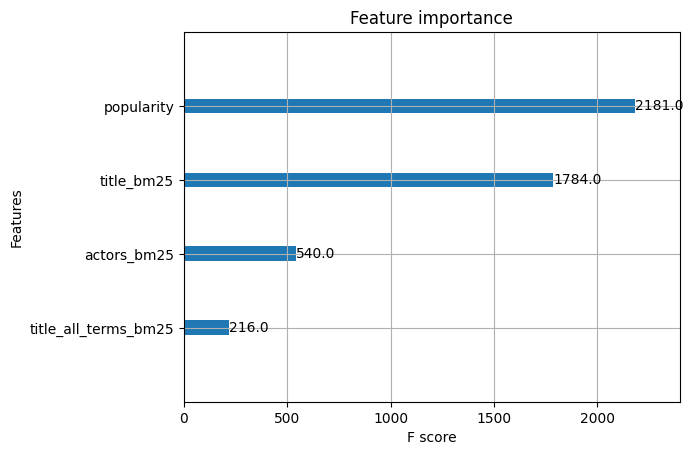

In [13]:
xgb.plot_importance(ranker, importance_type='weight')


## Importing the model to Elasticsearch

Once the model is trained you will be able to use Eland to send it to Elasticsearch.

Please note that the `MLModel.import_ltr_model` method contains the LTRModelConfig object, so you do not need to send it separately to configure feature extraction.


In [14]:
from eland.ml import MLModel

MLModel.import_ltr_model(
  es_client=es_client,
  model=ranker,
  model_id='ltr-model-xgboost',
  ltr_model_config=ltr_config,
  es_if_exists = 'replace'
)

## Using the rescorer
Once the model is uploaded to ES, you will be able to use it as a rescorer into the _search API, as shown in the example after:

```
POST /_search
{
   "query" : {
      "multi_match" : {
         "query": "star wars",
         "field": ["title", "overview", "actors", "director", "tags", "characters"]
      }
   },
   "rescore" : {
      "window_size" : 50,
      "learning_to_rank" : {
         "model_id": "ltr-model-xgboost",
         "params": { 
            "query": "star wars"
         }
      }
   }
}
```

In [15]:
query = 'star wars'

# First let's display the result when not using the rescorer:
[
  (movie['_source']['title'], movie['_score'],  movie['_id']) for movie in es_client.search(
    index=MOVIE_INDEX,
    query={ "multi_match": { "query": query, "fields": ["title", "overview", "actors", "director", "tags", "characters"] } }
  )['hits']['hits']
]

[('Star Wars', 10.972473, '11'),
 ('Star Wars: The Clone Wars', 9.924128, '12180'),
 ('After Porn Ends 2', 9.613241, '440249'),
 ('Andor: A Disney+ Day Special Look', 8.982841, '1022100'),
 ("Family Guy Presents: It's a Trap!", 8.840657, '278427'),
 ('Star Wars: The Rise of Skywalker', 8.053794, '181812'),
 ('Star Wars: The Force Awakens', 8.053794, '140607'),
 ('Star Wars: The Last Jedi', 8.053794, '181808'),
 ('Solo: A Star Wars Story', 8.053794, '348350'),
 ('The Star Wars Holiday Special', 8.053794, '74849')]

In [19]:
# Now let's display result using the rescorer:
[
  (movie['_source']['title'], movie['_score'], movie['_id']) for movie in es_client.search(
    index=MOVIE_INDEX,
    query={ "multi_match": { "query": query, "type": "best_fields", "fields": ["title", "overview", "actors", "director", "tags", "characters"] } },
    rescore={ "learning_to_rank": { "model_id": "ltr-model-xgboost", "params": {"query": query} }, "window_size": 100 }
  )['hits']['hits']
]

[('Star Wars', 4.580671, '11'),
 ('LEGO Star Wars Holiday Special', 1.9806126, '732670'),
 ('Star Wars: The Clone Wars', 1.8576434, '12180'),
 ('Star Wars: The Last Jedi', 1.7370756, '181808'),
 ('LEGO Star Wars Summer Vacation', 1.6153007, '980804'),
 ('Rogue One: A Star Wars Story', 1.5883299, '330459'),
 ('Star Wars: The Rise of Skywalker', 1.5681647, '181812'),
 ('Star Wars: The Force Awakens', 1.4801544, '140607'),
 ('LEGO Star Wars Terrifying Tales', 1.4480213, '857702'),
 ('Solo: A Star Wars Story', 1.1000854, '348350')]